![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/chinese_english_translation.png)

## Seq2Seq Learning

### Encoder-Decoder Architecture

![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/encoder_to_decoder.png)

### Sequence to Sequence

![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/seq2seq.png)

### Sequence to Sequence with Attention Mechanism

![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/seq2seq_attention.gif)

### Details of attention

![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/illustrated_attention.png)

![](https://nthu-datalab.github.io/ml/labs/12-1_Seq2Seq-Learning_Neural-Machine-Translation/imgs/score_functions.png)

## Neural Machine Translation

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

from pylab import *
from matplotlib.font_manager import FontProperties

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Prepare the dataset

In [3]:
# dataset path
# use the Chinese-English dataset
path_to_file = "./data/eng-chinese.txt"

### Data preprocessing

In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_eng(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/
    # python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    # replace several spaces with one space
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


def preprocess_chinese(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r'[" "]+', "", w)
    w = w.rstrip().strip()
    w = " ".join(list(w))  # add the space between words
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
# u means unicode encoder
en_sentence = u"May I borrow this book?"
chn_sentence = u"我可以借這本書麼？"
print(preprocess_eng(en_sentence))
print(preprocess_chinese(chn_sentence))
print(preprocess_chinese(chn_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
<start> 我 可 以 借 這 本 書 麼 ？ <end>
b'<start> \xe6\x88\x91 \xe5\x8f\xaf \xe4\xbb\xa5 \xe5\x80\x9f \xe9\x80\x99 \xe6\x9c\xac \xe6\x9b\xb8 \xe9\xba\xbc \xef\xbc\x9f <end>'


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, CHINESE]
def create_dataset(path, num_examples=None):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[w for w in l.split('\t')] for l in lines[:num_examples]]
    word_pairs = [[preprocess_eng(w[0]), preprocess_chinese(w[1])]
                  for w in word_pairs]

    # return two tuple: one tuple includes all English sentenses, and 
    # another tuple includes all Chinese sentenses
    return word_pairs


word_pairs = create_dataset(path_to_file)
# show the first twenty examples
word_pairs[:20]

[['<start> hi . <end>', '<start> 嗨 。 <end>'],
 ['<start> hi . <end>', '<start> 你 好 。 <end>'],
 ['<start> run . <end>', '<start> 你 用 跑 的 。 <end>'],
 ['<start> wait ! <end>', '<start> 等 等 ！ <end>'],
 ['<start> hello ! <end>', '<start> 你 好 。 <end>'],
 ['<start> i try . <end>', '<start> 让 我 来 。 <end>'],
 ['<start> i won ! <end>', '<start> 我 赢 了 。 <end>'],
 ['<start> oh no ! <end>', '<start> 不 会 吧 。 <end>'],
 ['<start> cheers ! <end>', '<start> 乾 杯 ! <end>'],
 ['<start> he ran . <end>', '<start> 他 跑 了 。 <end>'],
 ['<start> hop in . <end>', '<start> 跳 进 来 。 <end>'],
 ['<start> i lost . <end>', '<start> 我 迷 失 了 。 <end>'],
 ['<start> i quit . <end>', '<start> 我 退 出 。 <end>'],
 ['<start> i m ok . <end>', '<start> 我 沒 事 。 <end>'],
 ['<start> listen . <end>', '<start> 听 着 。 <end>'],
 ['<start> no way ! <end>', '<start> 不 可 能 ！ <end>'],
 ['<start> no way ! <end>', '<start> 没 门 ！ <end>'],
 ['<start> really ? <end>', '<start> 你 确 定 ？ <end>'],
 ['<start> try it . <end>', '<start> 试 试 吧 。 <end>'],
 ['

In [7]:
en, chn = zip(*create_dataset(path_to_file))
print(en[-1])
print(chn[-1])
# show the size of the dataset
assert len(en) == len(chn)
print("Size:", len(en))

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如 果 一 個 人 在 成 人 前 沒 有 機 會 習 得 目 標 語 言 ， 他 對 該 語 言 的 認 識 達 到 母 語 者 程 度 的 機 會 是 相 當 小 的 。 <end>
Size: 20289


In [8]:
def max_length(tensor):
    # padding the sentence to max_length
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    # generate a dictionary, e.g. word -> index(of the dictionary)
    lang_tokenizer.fit_on_texts(lang)

    # output the vector sequences, e.g. [1, 7, 237, 3, 2]
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # padding sentences to the same length
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    # regard Chinese as source sentence, regard English as target sentence
    targ_lang, inp_lang = zip(*create_dataset(path, num_examples))

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
# Try experimenting with the size of that dataset
# num_examples = 10000, if num examples = None means no limitation
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(
    path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(
    target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 95-5 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.05)

# Show length of the training data and validation data
print("# training data: {:d}\n# test data: {:d}".format(len(input_tensor_train), len(input_tensor_val)))

# training data: 19274
# test data: 1015


In [10]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> 他
21 ----> 們
11 ----> 在
83 ----> 吃
8 ----> 他
21 ----> 們
5 ----> 的
694 ----> 蘋
142 ----> 果
3 ----> 。
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
53 ----> they
33 ----> are
362 ----> eating
200 ----> their
590 ----> apples
3 ----> .
2 ----> <end>


### Create a tf.data dataset


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
# 0 is a reserved index that won't be assigned to any word, so the size of vocabulary should add 1
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 46]), TensorShape([128, 38]))

### Encoder

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=vocab_inp_size=9394, embedding_dim=256 enc_units=1024 batch_sz=128
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # x is the training data with shape == (batch_size, max_length)  -> (128, 46)
        # which means there are batch_size sentences in one batch, the length of each sentence is max_length
        # hidden state shape == (batch_size, units) -> (128, 1024)
        # after embedding, x shape == (batch_size, max_length, embedding_dim) -> (128, 46, 256)
        x = self.embedding(x)
        
        # output contains the state(in GRU, the hidden state and the output are same) from all timestamps,
        # output shape == (batch_size, max_length, units) -> (128, 46, 1024)
        # state is the hidden state of the last timestamp, shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x, initial_state=hidden)
        
        return output, state

    def initialize_hidden_state(self):
        # initialize the first state of the gru,  shape == (batch_size, units) -> (128, 1024)
        return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# the output and the hidden state of GRU is equal
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape: (batch size, sequence length, units) (128, 46, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


### Attention

In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape == (batch_size, max_length, hidden_size)
        context_vector = attention_weights * values
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 46, 1)


### Decoder

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        # vocab_size=vocab_tar_size=6082, embedding_dim=256, dec_units=1024, batch_sz=128
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # the dimension of the output is the vocab size, through the softmax function,
        # this layer will return the probability of each word in the dictory
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # This function outputs a result at each timestamp
        # The hidden state of fisrt timestamp in the decoder is 
        # the hidden state of last timestamp in the encoder
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # concatenate the input x and the context_vector, as the input of the GRU
        # context_vector shape == (batch_size, units) -> (128, 1024)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) -> (128, 1, 1024 + 256)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # get the output and state of the current timestamp
        # output shape == (batch_size, 1, units) -> (128, 1, 1024) 
        # state shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x)

        # output shape == (batch_size, hidden_size) -> (128, 1024)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab) -> (128, 6082)
        x = self.fc(output)

        return x, state, attention_weights

In [17]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 6082)


### Define the optimizer and the loss function


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    """Calculate the loss value
    Args:
        real: the true label  shape == (batch_size,) -> (128,)
        pred: the probability of each word from the vocabulary, is the output from the decoder 
                 shape == (batch_size, vocab_size) -> (128, 6082)

    Returns: 
        the average loss of the data in a batch size
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoints (Object-based saving)


In [19]:
checkpoint_dir = './checkpoints/chinese-eng'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        # feed the <start> as the first input of the decoder
        # dec input shape == (batch_size, 1) -> (128, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        # because of the data preprocessing(add a start token to the sentence)
        # the first word is <start>, so t starts from 1(not 0)
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # targ[:, t] is the true label(index of the word) of every sentence(in a batch) 
            # at the current timestamp
            # like [  85   18   25   25  ···  1047   79   13], shape == (batch_size,) -> (128,)
            # predictions shape == (batch_size, vocab_size) -> (128, 6082)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
# set the epochs for training
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

### Translate

In [21]:
def evaluate(sentence):
    """Translate a sentence
    Args:
        sentence: the test sentence        
    """
    
    # max_length_targ 38, max_length_inp 64
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_chinese(sentence)

    # convert each word to the index in the test sentence
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # hidden shape == (1, 1024)
    hidden = [tf.zeros((1, units))]
    
    # enc out shape == (1, max_length_inp, 1024) -> (1, 46, 1024)
    # enc hidden shape == (1, 1024)
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # get the index which has the highest probability
        predicted_id = tf.argmax(predictions[0]).numpy()
        #  convert the index to the word
        result += targ_lang.index_word[predicted_id] + ' '

        # when the decoder predicts the end, stop prediction
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted id is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=font)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [22]:
checkpoint_dir = './checkpoints/chinese-eng'
print(tf.train.latest_checkpoint(checkpoint_dir))

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./checkpoints/chinese-eng\ckpt-10


Input: <start> 你 今 晚 會 去 派 對 嗎 ? <end>
Predicted translation: will you go to the party tonight ? <end> 


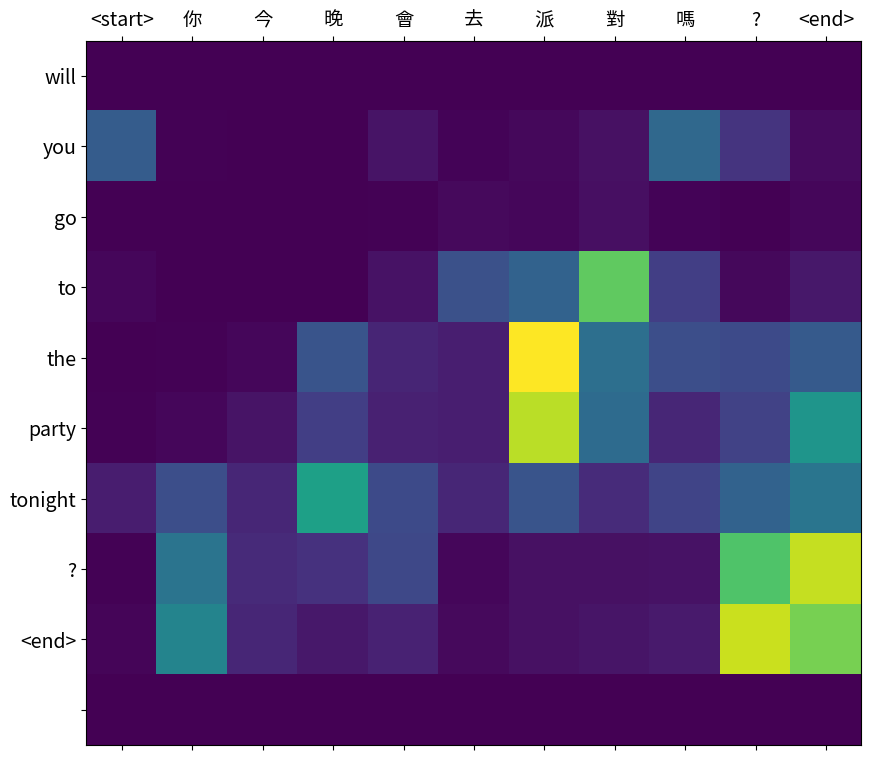

In [23]:
translate('你今晚會去派對嗎?')

Input: <start> 我 有 一 隻 貓 。 <end>
Predicted translation: i have a cat . <end> 


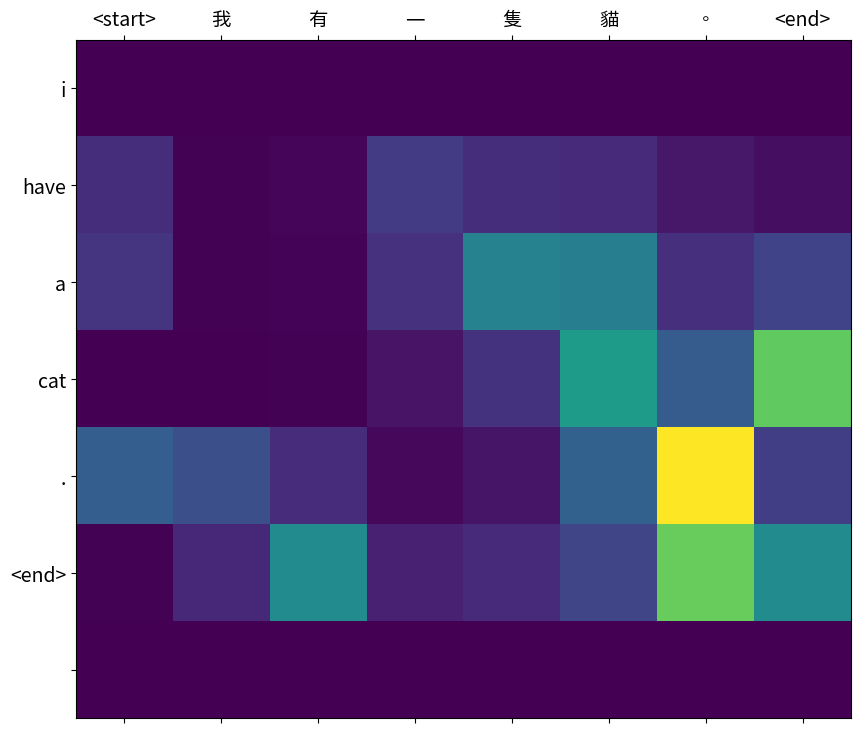

In [24]:
translate('我有一隻貓。')

Input: <start> 她 明 年 會 去 美 國 嗎 ? <end>
Predicted translation: will she go to america next year ? <end> 


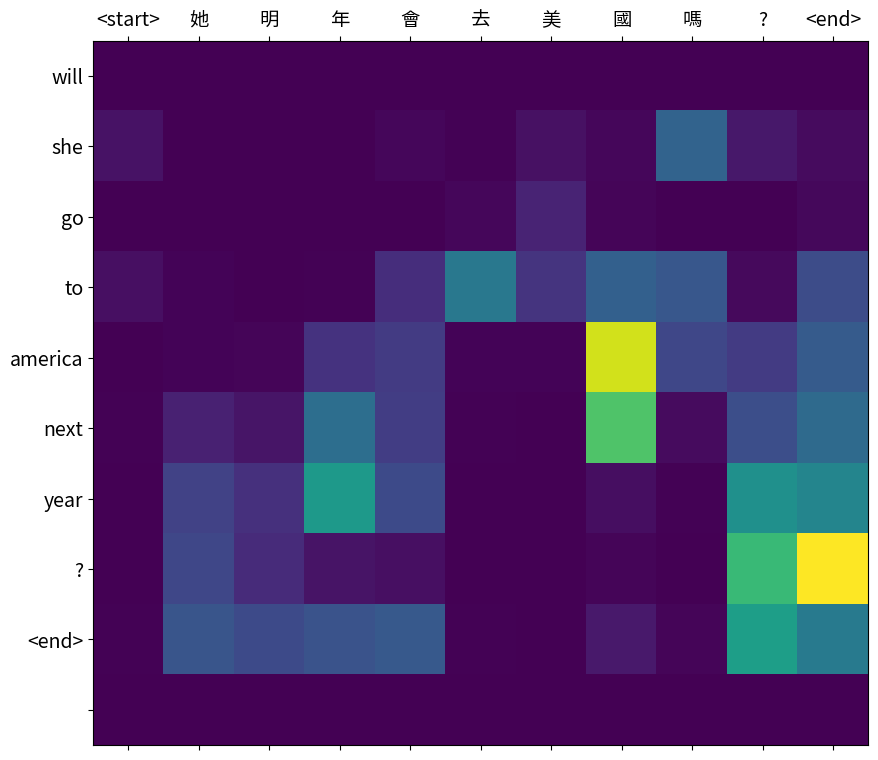

In [25]:
translate('她明年會去美國嗎?')

## <center>Assignment</center>

### Sentiment Analysis

In this assignment, we will train a seq2seq model with **Luong Attention** to solve a sentiment analysis task with the IMDB dataset. The formula of score function in Luong Attention is: 

$$\text{score}(s_t, h_i) = s_t^T W_a h_i$$

This dataset contains 50,000 sentences with binary labels (positive and negative). Here we split the data into training and test sets. It is worth mentioning that different from the neural machine translation, the decoder used for sentiment analysis is 4-fully-connected layers, rather than GRU layer since here we want to make a binary classification.

In [26]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [28]:
# load the dataset
movie_reviews = pd.read_csv("./data/IMDB Dataset.csv")

### Data preprocessing

In [29]:
# check if there is any null value in the dataset
movie_reviews.isnull().values.any()

False

In [30]:
# show the size of the dataset
movie_reviews.shape

(50000, 2)

In [31]:
# show the first five data in the dataset
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [32]:
movie_reviews["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [33]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [34]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

# replace the positive with 1, replace the negative with 0
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [35]:
# Split the training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("# training data: {:d}\n# test data: {:d}".format(len(X_train), len(X_test)))

# training data: 40000
# test data: 10000


In [36]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_len = 100
# padding sentences to the same length
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=max_len)

In [37]:
# show the preprocessed data
X_train[0]

array([   1,  296,  140, 2854,    2,  405,  614,    1,  263,    5, 3514,
        977,    4,   25,   37,   11, 1237,  215,   62,    2,   35,    5,
         27,  217,   24,  189, 1430,    7, 1068,   15, 4868,   81,    1,
        221,   63,  351,   64,   52,   24,    4, 3547,   13,    6,   19,
        192,    4, 8148,  859, 3430, 1720,   17,   23,    4,  158,  194,
        175,  106,    9, 1604,  461,   71,  218,    4,  321,    2, 3431,
         31,   20,   47,   68, 1844, 4668,   11,    6, 1365,    8,   16,
          5, 3475, 1990,   14,   59,    1, 2380,  460,  518,    2,  170,
       2524, 2698, 1745,    4,  573,    6,   33,    1, 3750,  198,  345,
       3812])

In [38]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 128
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
# only reserve 10000 words
vocab_size = 10000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 100]), TensorShape([128]))

In [39]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=10000, embedding_dim=256 enc_units=1024 batch_sz=64
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # x is the training data with shape == (batch_size，max_length)  -> (128, 100)
        # which means there are batch_size sentences in one batch, the length of each sentence is max_length
        # hidden state shape == (batch_size, units) -> (128, 1024)
        # after embedding, x shape == (batch_size, max_length, embedding_dim) -> (128, 100, 256)
        x = self.embedding(x)
        
        # output contains the state(in GRU, the hidden state and the output are same) from all timestamps,
        # output shape == (batch_size, max_length, units) -> (128, 100, 1024)
        # state is the hidden state of the last timestamp, shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x, initial_state=hidden)
        
        return output, state

    def initialize_hidden_state(self):
        # initialize the first state of the gru,  shape == (batch_size, units) -> (128, 1024)
        return tf.zeros((self.batch_sz, self.enc_units))

In [40]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
# the output and the hidden state of GRU is equal
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape: (batch size, sequence length, units) (128, 100, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


In [41]:
class LuongAttention(tf.keras.Model):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        # TODO: Complete the function.
        pass

    def call(self, query, values):
        # TODO: Implement the Luong attention.
        pass

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        
        # pass through four fully connected layers, the model will return 
        # the probability of the positivity of the sentence
        self.fc_1 = tf.keras.layers.Dense(2048)
        self.fc_2 = tf.keras.layers.Dense(512)
        self.fc_3 = tf.keras.layers.Dense(64)
        self.fc_4 = tf.keras.layers.Dense(1)

        # used for attention
        self.attention = LuongAttention(self.dec_units)

    def call(self, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        output = self.fc_1(context_vector)
        output = self.fc_2(output)
        output = self.fc_3(output)
        output = self.fc_4(output)

        return output, attention_weights

In [ ]:
decoder = Decoder(units, BATCH_SIZE)
sample_decoder_output, _ = decoder(sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './checkpoints/sentiment-analysis'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # passing enc_output to the decoder
        predictions, _ = decoder(enc_hidden, enc_output)

        loss = loss_function(targ, predictions)

    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [ ]:
# set the epochs for training
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
print(tf.train.latest_checkpoint(checkpoint_dir))
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
@tf.function
def test_step(inp, enc_hidden):
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        predictions, attention_weights = decoder(enc_hidden, enc_output)
    return predictions, attention_weights

In [ ]:
def evaluate(test_data):
    enc_hidden = encoder.initialize_hidden_state()
    
    for batch, (inp, targ) in enumerate(test_data):
        if len(inp) != BATCH_SIZE:
            enc_hidden = tf.zeros((len(inp), units))
        # make prediction
        if batch == 0:
            predictions, attention_weights = test_step(inp, enc_hidden)
            predictions, attention_weights = predictions.numpy(), attention_weights.numpy()
        else:
            _predictions, _attention_weights = test_step(inp, enc_hidden)
            _predictions, _attention_weights = _predictions.numpy(), _attention_weights.numpy()
            predictions = np.concatenate((predictions, _predictions))
            attention_weights = np.concatenate((attention_weights, _attention_weights))
    
    predictions = np.squeeze(predictions)
    attention_weights = np.squeeze(attention_weights)
    predictions[np.where(predictions < 0.5)] = 0
    predictions[np.where(predictions >= 0.5)] = 1
    return predictions, attention_weights

In [ ]:
y_pred, attention_weights = evaluate(test_dataset)

In [ ]:
print('Accuracy: ', (y_pred == y_test).sum() / len(y_test))

We reach ~84.5% accuracy with only 10 epochs! Not bad at all! Besides the nice accuracy, let's try to do some more fascinating things. How about **visualizing** our results?

In addition to the better performance, another advantage of the attention mechanism is we can visualize the attention weights. Here we demonstrate which word the model focuses on the most by coloring the words corresponding to the ten largest weights.

In [ ]:
from termcolor import colored
for idx, data in enumerate(X_test[:10]):
    print('y_true: {:d}'.format(y_test[idx]))
    print('y_predict: {:.0f}'.format(y_pred[idx]))
    
    # get the twenty most largest attention weights
    large_weights_idx = np.argsort(attention_weights[idx])[::-1][:10]
    
    for _idx in range(len(data)):
        word_idx = data[_idx]
        if word_idx != 0:
            if _idx in large_weights_idx:
                print(colored(tokenizer.index_word[word_idx], 'red'), end=' ')
                # try this if termcolor is not working properly
                # print(f'\033[31m{tokenizer.index_word[word_idx]}\033[0m', end=' ')
            else:
                print(tokenizer.index_word[word_idx], end=' ')
    print("\n\n")

Pretty interesting, isn't it?

### What you should do:

- Complete the **TODO** part: implement the **Luong Attention**, where the formula of the score function is:

$$\text{score}(s_t, h_i) = s_t^T W_a h_i$$

, where

- $h_i$: hidden state of the encoder
- $s_t$: hidden state of the decoder
- $W_a$: the trainable weights


### Dataset:

[Here](https://drive.google.com/drive/folders/1zTElf5u_655cEPKQZU1ZPsho0dBBDbY7?usp=sharing) you can download both datasets used in neural machine translation and sentiment analysis. Moreover, if you don't have Chinese font to display in plot_attention(), you can also download the font in the above link. The font we used here is called "台北黑體", which is an open source, you can find more details on [this page](https://sites.google.com/view/jtfoundry/).

### Requirements:

- The accuracy should be at least **0.80**.
- Show the **10-most-focused words** in the sentence.
- Only need to show the **first 10 results** in the test data.
- Submit on eeclass your code file `Lab12-1_{student id}.ipynb.`
- No need to submit the checkpoints file, but you should show the results in the notebook.
- Deadline: **2023-11-23 (Thu) 23:59**.
